## UNZIPPING DATA

In [1]:
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 47.0 MB/s eta 0:00:00


In [2]:
!unzip archive.zip

Archive:  archive.zip
   creating: lfw_funneled/
   creating: lfw_funneled/George_HW_Bush/
  inflating: lfw_funneled/George_HW_Bush/George_HW_Bush_0001.jpg  
  inflating: lfw_funneled/George_HW_Bush/George_HW_Bush_0002.jpg  
  inflating: lfw_funneled/George_HW_Bush/George_HW_Bush_0003.jpg  
  inflating: lfw_funneled/George_HW_Bush/George_HW_Bush_0004.jpg  
  inflating: lfw_funneled/George_HW_Bush/George_HW_Bush_0005.jpg  
  inflating: lfw_funneled/George_HW_Bush/George_HW_Bush_0006.jpg  
  inflating: lfw_funneled/George_HW_Bush/George_HW_Bush_0007.jpg  
  inflating: lfw_funneled/George_HW_Bush/George_HW_Bush_0008.jpg  
  inflating: lfw_funneled/George_HW_Bush/George_HW_Bush_0009.jpg  
  inflating: lfw_funneled/George_HW_Bush/George_HW_Bush_0010.jpg  
  inflating: lfw_funneled/George_HW_Bush/George_HW_Bush_0011.jpg  
  inflating: lfw_funneled/George_HW_Bush/George_HW_Bush_0012.jpg  
  inflating: lfw_funneled/George_HW_Bush/George_HW_Bush_0013.jpg  
   creating: lfw_funneled/Curtis_Stran

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras as ks
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import random as rand
import seaborn as sns
import scipy as sci
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
import os
import cv2
from math import log10, sqrt
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet50 import decode_predictions
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.utils import to_categorical
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
import mtcnn
from PIL import Image
from scipy import ndimage
from tqdm import tqdm

**LOADING MTCNN MODEL**

In [4]:
detector = mtcnn.MTCNN()

LOADING DATA AND EXTRACTING FACE FROM THE PICTURE

In [5]:
Training = []
Result_Training = []
for dirname, _, filenames in os.walk('/content/lfw_funneled/'):
    for filename in filenames:
        img = cv2.imread(os.path.join(dirname, filename))
        Result_Training.append(filename.split("_")[0])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        result = detector.detect_faces(img)
        x1, y1, h, w = result[0]["box"]
        x2, y2 = x1 + w, y1 + h
        face = img[y1:y2, x1:x2]
        print("Face Dimentions: ", face.shape)
        img = cv2.resize(face, (128, 128))
        Training.append(img)
np.array(Training).shape, np.array(Result_Training).shape

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 88ms/step
Face Dimentions:  (95, 128, 3)
1/1 [==============================] - 0s 59ms/step
Face Dimentions:  (101, 121, 3)
1/1 [==============================] - 0s 33ms/step
Face Dimentions:  (91, 123, 3)
1/1 [==============================] - 0s 20ms/step
Face Dimentions:  (90, 128, 3)
1/1 [==============================] - 0s 19ms/step
Face Dimentions:  (100, 126, 3)
1/1 [==============================] - 0s 20ms/step
Face Dimentions:  (92, 125, 3)
1/1 [==============================] - 0s 20ms/step
Face Dimentions:  (94, 138, 3)
1/1 [==============================] - 0s 20ms/step
Face Dimentions:  (98, 129, 3)
1/1 [==============================] - 0s 22ms/step
Face Dimentions:  (101, 140, 3)
1/1 [==============================] - 0s 21ms/step
Face Dimentions:  (97, 125, 3)
1/1 [==============================] - 0s 21ms/step
Face Dimentions:  (89, 126, 3)
1/1 [============================

((621, 128, 128, 3), (621,))

# DATA PREPROCESSING

In [6]:
Result = Result_Training
np.array(Result).shape

(621,)

In [7]:
lb = LabelEncoder()
Result = lb.fit_transform(Result)

In [8]:
Temp = []
for i in Result:
    temp = []
    temp.append(i)
    Temp.append(temp)
output_matrix = to_categorical(Temp)
total = output_matrix.shape[1]
output_matrix.shape

(621, 48)

FUCTIONS FOR PSNR AND SSIM

In [9]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return round(psnr, 2)

In [10]:
def SSIMS(original, compressed):
  return round(ssim(original, compressed, multichannel=True), 2)

In [11]:
def Print_ALL(original, compressed):
  print("PSRN: ", PSNR(original, compressed))
  print("SSIM: ", SSIMS(original, compressed))

In [12]:
def Print_data(y_real, y_pre):
  cm = confusion_matrix(y_real, y_pre)
  for c in range(27):
      tp = cm[c,c]
      fp = sum(cm[:,c]) - cm[c,c]
      fn = sum(cm[c,:]) - cm[c,c]
      tn = sum(np.delete(sum(cm)-cm[c,:],c))

      recall = tp/(tp+fn)
      precision = tp/(tp+fp)
      specificity = tn/(tn+fp)
      f1_score = 2*((precision*recall)/(precision+recall))
      

      #print(f"for class {c}: acc {accuracy}, recall {recall},\
      #      precision {precision}, f1 {f1_score}")
      print("for class {}: recall {}, specificity {}\
            precision {}, f1 {}".format(c,round(recall,4), round(specificity,4), round(precision,4),round(f1_score,4)))

DOWNSAMPLING CODE FOR IMAGES TO CONVERT THEM TO LR

In [13]:
def down_sampling(ar, fact):
    res = ar[::fact, ::fact, :]
    return res

In [14]:
LR = []
for i in tqdm(range(len(Training)),desc="CONVERTING"):
  LR.append(down_sampling(Training[i], 4))
np.array(LR).shape

CONVERTING: 100%|██████████| 621/621 [00:00<00:00, 289246.28it/s]


(621, 32, 32, 3)

TRUTH GROUND IMAGES AND LR IMAGES

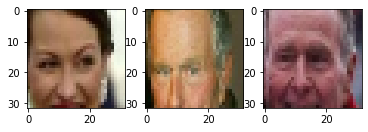

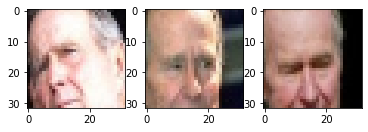

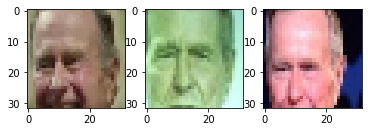

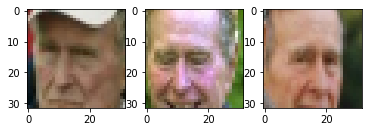

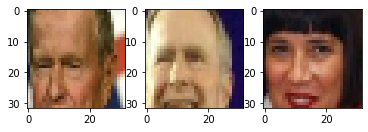

In [15]:
for i in range(0, 15, 3):
    f, axarr = plt.subplots(nrows=1,ncols=3)
    plt.sca(axarr[0]); 
    plt.imshow(LR[i])
    plt.sca(axarr[1]); 
    plt.imshow(LR[i+1])
    plt.sca(axarr[2]); 
    plt.imshow(LR[i+2])
    plt.show()

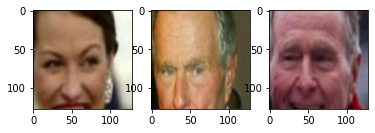

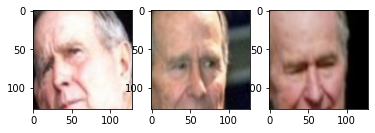

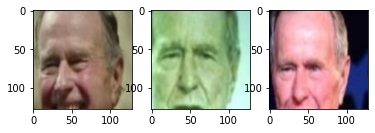

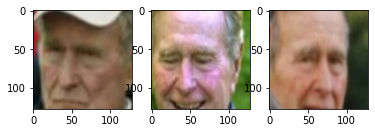

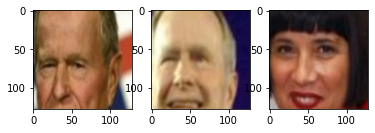

In [16]:
for i in range(0, 15, 3):
    f, axarr = plt.subplots(nrows=1,ncols=3)
    plt.sca(axarr[0]); 
    plt.imshow(Training[i])
    plt.sca(axarr[1]); 
    plt.imshow(Training[i+1])
    plt.sca(axarr[2]); 
    plt.imshow(Training[i+2])
    plt.show()

# LAPSRN

In [17]:
super_res = cv2.dnn_superres.DnnSuperResImpl_create()
super_res.readModel('/content/LapSRN_x4.pb')
super_res.setModel('lapsrn',4)

In [18]:
Temp_Train = []
for i in tqdm(range(len(LR)),desc="UPSAMPLING"):
  img = super_res.upsample(LR[i])
  Temp_Train.append(img)

UPSAMPLING: 100%|██████████| 621/621 [00:30<00:00, 20.46it/s]


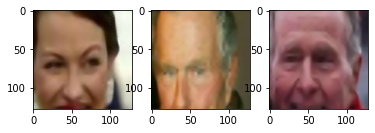

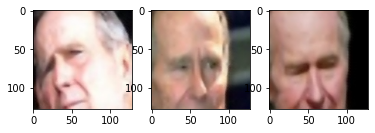

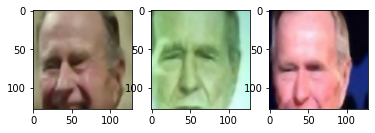

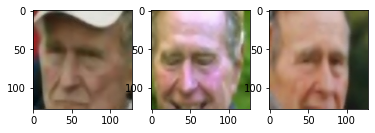

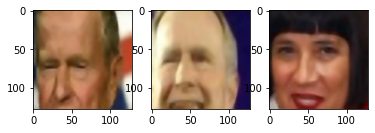

In [19]:
for i in range(0, 15, 3):
    f, axarr = plt.subplots(nrows=1,ncols=3)
    plt.sca(axarr[0]); 
    plt.imshow(Temp_Train[i])
    plt.sca(axarr[1]); 
    plt.imshow(Temp_Train[i+1])
    plt.sca(axarr[2]); 
    plt.imshow(Temp_Train[i+2])
    plt.show()

**RESULT OF UPSAMPLING**

In [20]:
Print_ALL(np.array(Training), np.array(Temp_Train))

PSRN:  31.14


<ipython-input-10-f03d19e3d0da>:2: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return round(ssim(original, compressed, multichannel=True), 2)


SSIM:  0.94


**TAINING AND TESTING DATA**

In [21]:
Temp_Train = np.array(Temp_Train)
output_matrix =  np.array(output_matrix)

# RESNET50 MODEL

In [22]:
resnet_model = Sequential()
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(128, 128, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(2048, activation='relu'))
resnet_model.add(Dense(total, activation='softmax'))

94765736/94765736 [==============================] - 1s 0us/step


In [23]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_7 (Dense)             (None, 2048)              4196352   
                                                                 
 dense_8 (Dense)             (None, 48)                98352     
                                                                 
Total params: 27,882,416
Trainable params: 4,294,704
Non-trainable params: 23,587,712
_________________________________________________________________


In [24]:
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = resnet_model.fit(Temp_Train, output_matrix, batch_size=32, epochs=20)

Epoch 1/20
20/20 [==============================] - 9s 87ms/step - loss: 4.1467 - accuracy: 0.3961 - precision: 0.5079 - recall: 0.3124
Epoch 2/20
20/20 [==============================] - 1s 35ms/step - loss: 1.2560 - accuracy: 0.7005 - precision: 0.8783 - recall: 0.5346
Epoch 3/20
20/20 [==============================] - 1s 39ms/step - loss: 0.6459 - accuracy: 0.8438 - precision: 0.9354 - recall: 0.7456
Epoch 4/20
20/20 [==============================] - 1s 39ms/step - loss: 0.3205 - accuracy: 0.9243 - precision: 0.9677 - recall: 0.8680
Epoch 5/20
20/20 [==============================] - 1s 38ms/step - loss: 0.1434 - accuracy: 0.9775 - precision: 0.9917 - recall: 0.9565
Epoch 6/20
20/20 [==============================] - 1s 35ms/step - loss: 0.0770 - accuracy: 0.9936 - precision: 0.9984 - recall: 0.9871
Epoch 7/20
20/20 [==============================] - 1s 34ms/step - loss: 0.0383 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 8/20
20/20 [==============================

# IMPORTANT PLOTS

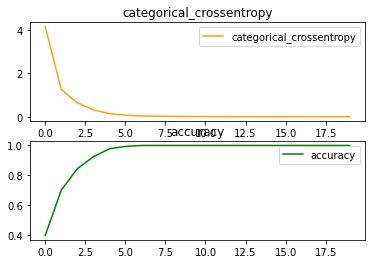

In [25]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.legend(["categorical_crossentropy"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.legend(["accuracy"])
plt.title("accuracy")
plt.show()

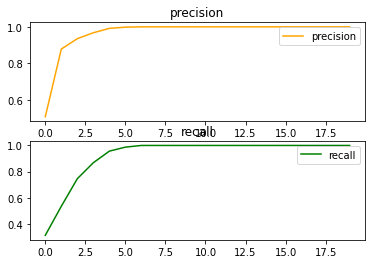

In [26]:
plt.subplot(2,1,1)
plt.plot(history.history["precision"], color='orange')
plt.legend(["precision"])
plt.title("precision")
plt.subplot(2,1,2)
plt.plot(history.history["recall"], color='green')
plt.legend(["recall"])
plt.title("recall")
plt.show()

# ANSWERS

In [27]:
answer = resnet_model.evaluate(Temp_Train, output_matrix)
print("ACCURACY: ", round(answer[1], 2))
print("LOSS: ", round(answer[0], 2))
print("Precision: ", round(answer[2], 2))
print("Recall: ", round(answer[3], 2))

20/20 [==============================] - 2s 37ms/step - loss: 0.0034 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
ACCURACY:  1.0
LOSS:  0.0
Precision:  1.0
Recall:  1.0


In [28]:
pre = resnet_model.predict(Temp_Train)

20/20 [==============================] - 2s 31ms/step


In [29]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(output_matrix[i]))

<Axes: >

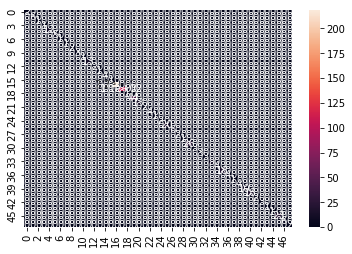

In [30]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

In [31]:
Print_data(y_real, y_pre)

for class 0: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 1: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 2: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 3: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 4: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 5: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 6: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 7: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 8: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 9: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 10: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 11: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 12: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 13: recall 1.0, specifici

# MOBILENETv2

In [32]:
mobile_model = Sequential()
pretrained_model= MobileNetV2(include_top=False,
                   input_shape=(128, 128, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

mobile_model.add(pretrained_model)
mobile_model.add(Flatten())
mobile_model.add(Dense(2048, activation='relu'))
mobile_model.add(Dense(total, activation='softmax'))

9406464/9406464 [==============================] - 0s 0us/step


In [33]:
mobile_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = mobile_model.fit(Temp_Train, output_matrix, batch_size=32, epochs=20)

Epoch 1/20
20/20 [==============================] - 4s 28ms/step - loss: 3.4040 - accuracy: 0.2899 - precision_1: 0.3333 - recall_1: 0.1369
Epoch 2/20
20/20 [==============================] - 0s 17ms/step - loss: 2.3557 - accuracy: 0.4026 - precision_1: 0.5776 - recall_1: 0.1498
Epoch 3/20
20/20 [==============================] - 0s 16ms/step - loss: 2.0976 - accuracy: 0.4734 - precision_1: 0.6878 - recall_1: 0.2093
Epoch 4/20
20/20 [==============================] - 0s 17ms/step - loss: 1.8878 - accuracy: 0.4928 - precision_1: 0.7184 - recall_1: 0.2834
Epoch 5/20
20/20 [==============================] - 0s 16ms/step - loss: 1.7450 - accuracy: 0.5169 - precision_1: 0.7234 - recall_1: 0.3285
Epoch 6/20
20/20 [==============================] - 0s 16ms/step - loss: 1.6642 - accuracy: 0.5523 - precision_1: 0.6850 - recall_1: 0.3011
Epoch 7/20
20/20 [==============================] - 0s 16ms/step - loss: 1.5380 - accuracy: 0.5330 - precision_1: 0.7166 - recall_1: 0.3543
Epoch 8/20
20/20 [==

**Graphs**

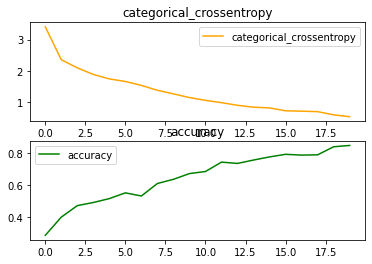

In [34]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.legend(["categorical_crossentropy"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.legend(["accuracy"])
plt.title("accuracy")
plt.show()

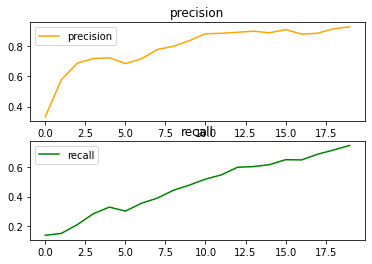

In [35]:
plt.subplot(2,1,1)
plt.plot(history.history["precision_1"], color='orange')
plt.legend(["precision"])
plt.title("precision")
plt.subplot(2,1,2)
plt.plot(history.history["recall_1"], color='green')
plt.legend(["recall"])
plt.title("recall")
plt.show()

**Answers**

In [36]:
answer = mobile_model.evaluate(Temp_Train, output_matrix)
print("ACCURACY: ", round(answer[1], 2))
print("LOSS: ", round(answer[0], 2))
print("Precision: ", round(answer[2], 2))
print("Recall: ", round(answer[3], 2))

20/20 [==============================] - 2s 19ms/step - loss: 0.4419 - accuracy: 0.9018 - precision_1: 0.9682 - recall_1: 0.7842
ACCURACY:  0.9
LOSS:  0.44
Precision:  0.97
Recall:  0.78


In [37]:
pre = mobile_model.predict(Temp_Train)

20/20 [==============================] - 1s 17ms/step


In [38]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(output_matrix[i]))

<Axes: >

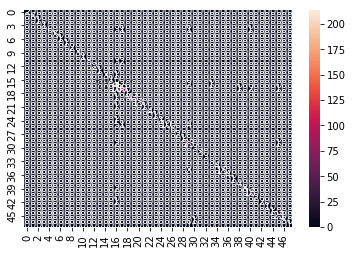

In [39]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

In [40]:
Print_data(y_real, y_pre)

for class 0: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 1: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 2: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 3: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 4: recall 0.5, specificity 1.0            precision 1.0, f1 0.6667
for class 5: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 6: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 7: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 8: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 9: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 10: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 11: recall 0.6154, specificity 1.0            precision 1.0, f1 0.7619
for class 12: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 13: recall 1.0, 

# EDSR MODEL

In [41]:
super_res = cv2.dnn_superres.DnnSuperResImpl_create()
super_res.readModel('/content/EDSR_x4.pb')
super_res.setModel('edsr',4)

In [42]:
Temp_Train = []
for i in tqdm(range(len(LR)),desc="UPSAMPLING"):
  img = super_res.upsample(LR[i])
  Temp_Train.append(img)

UPSAMPLING: 100%|██████████| 621/621 [08:28<00:00,  1.22it/s]


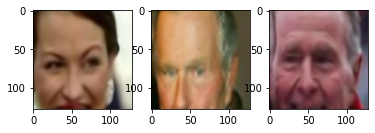

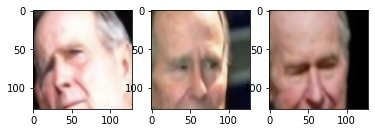

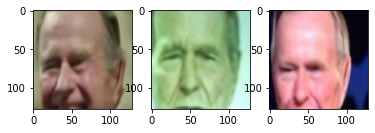

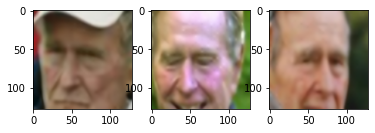

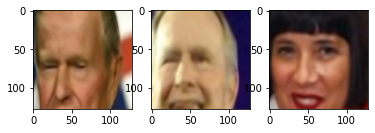

In [43]:
for i in range(0, 15, 3):
    f, axarr = plt.subplots(nrows=1,ncols=3)
    plt.sca(axarr[0]); 
    plt.imshow(Temp_Train[i])
    plt.sca(axarr[1]); 
    plt.imshow(Temp_Train[i+1])
    plt.sca(axarr[2]); 
    plt.imshow(Temp_Train[i+2])
    plt.show()

**Comapring The SR result**

In [44]:
Print_ALL(np.array(Training), np.array(Temp_Train))

PSRN:  31.17


<ipython-input-10-f03d19e3d0da>:2: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return round(ssim(original, compressed, multichannel=True), 2)


SSIM:  0.94


**TESTING AND TRAINING**

In [45]:
Temp_Train = np.array(Temp_Train)
output_matrix =  np.array(output_matrix)

# RESNET50 MODEL

In [46]:
resnet_model = Sequential()
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(128, 128, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(2048, activation='relu'))
resnet_model.add(Dense(total, activation='softmax'))

In [47]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_11 (Dense)            (None, 2048)              4196352   
                                                                 
 dense_12 (Dense)            (None, 48)                98352     
                                                                 
Total params: 27,882,416
Trainable params: 4,294,704
Non-trainable params: 23,587,712
_________________________________________________________________


In [48]:
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = resnet_model.fit(Temp_Train, output_matrix, batch_size=32, epochs=20)

Epoch 1/20
20/20 [==============================] - 5s 39ms/step - loss: 4.1332 - accuracy: 0.3688 - precision_2: 0.4930 - recall_2: 0.2834
Epoch 2/20
20/20 [==============================] - 1s 34ms/step - loss: 1.2339 - accuracy: 0.6683 - precision_2: 0.8422 - recall_2: 0.5330
Epoch 3/20
20/20 [==============================] - 1s 35ms/step - loss: 0.6002 - accuracy: 0.8583 - precision_2: 0.9525 - recall_2: 0.7424
Epoch 4/20
20/20 [==============================] - 1s 35ms/step - loss: 0.2933 - accuracy: 0.9163 - precision_2: 0.9712 - recall_2: 0.8680
Epoch 5/20
20/20 [==============================] - 1s 35ms/step - loss: 0.1234 - accuracy: 0.9839 - precision_2: 0.9917 - recall_2: 0.9597
Epoch 6/20
20/20 [==============================] - 1s 35ms/step - loss: 0.0771 - accuracy: 0.9919 - precision_2: 0.9967 - recall_2: 0.9855
Epoch 7/20
20/20 [==============================] - 1s 34ms/step - loss: 0.0358 - accuracy: 1.0000 - precision_2: 1.0000 - recall_2: 0.9984
Epoch 8/20
20/20 [==

**graphs**

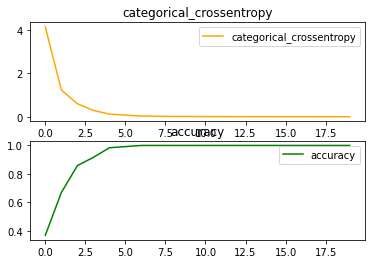

In [49]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.legend(["categorical_crossentropy"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.legend(["accuracy"])
plt.title("accuracy")
plt.show()

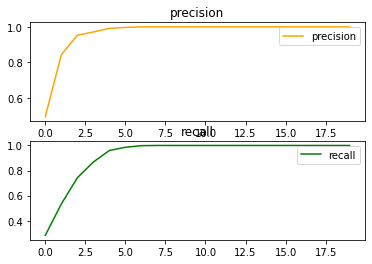

In [50]:
plt.subplot(2,1,1)
plt.plot(history.history["precision_2"], color='orange')
plt.legend(["precision"])
plt.title("precision")
plt.subplot(2,1,2)
plt.plot(history.history["recall_2"], color='green')
plt.legend(["recall"])
plt.title("recall")
plt.show()

**Answer**

In [51]:
answer = resnet_model.evaluate(Temp_Train, output_matrix)
print("ACCURACY: ", round(answer[1], 2))
print("LOSS: ", round(answer[0], 2))
print("Precision: ", round(answer[2], 2))
print("Recall: ", round(answer[3], 2))

20/20 [==============================] - 2s 41ms/step - loss: 0.0029 - accuracy: 1.0000 - precision_2: 1.0000 - recall_2: 1.0000
ACCURACY:  1.0
LOSS:  0.0
Precision:  1.0
Recall:  1.0


In [52]:
pre = resnet_model.predict(Temp_Train)

20/20 [==============================] - 2s 31ms/step


In [53]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(output_matrix[i]))

<Axes: >

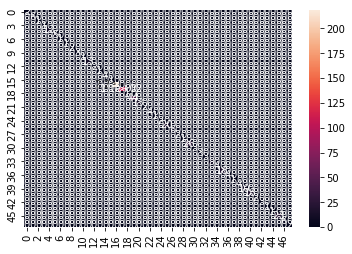

In [54]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

In [55]:
Print_data(y_real, y_pre)

for class 0: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 1: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 2: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 3: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 4: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 5: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 6: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 7: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 8: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 9: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 10: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 11: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 12: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 13: recall 1.0, specifici

# MOBILENETv2

In [56]:
mobile_model = Sequential()
pretrained_model= MobileNetV2(include_top=False,
                   input_shape=(128, 128, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

mobile_model.add(pretrained_model)
mobile_model.add(Flatten())
mobile_model.add(Dense(2048, activation='relu'))
mobile_model.add(Dense(total, activation='softmax'))

In [57]:
mobile_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = mobile_model.fit(Temp_Train, output_matrix, batch_size=32, epochs=20)

Epoch 1/20
20/20 [==============================] - 4s 20ms/step - loss: 3.2562 - accuracy: 0.3172 - precision_3: 0.4008 - recall_3: 0.1659
Epoch 2/20
20/20 [==============================] - 0s 16ms/step - loss: 2.3003 - accuracy: 0.4106 - precision_3: 0.5536 - recall_3: 0.2077
Epoch 3/20
20/20 [==============================] - 0s 16ms/step - loss: 1.9766 - accuracy: 0.4911 - precision_3: 0.6983 - recall_3: 0.2721
Epoch 4/20
20/20 [==============================] - 0s 16ms/step - loss: 1.8075 - accuracy: 0.5250 - precision_3: 0.7076 - recall_3: 0.3156
Epoch 5/20
20/20 [==============================] - 0s 17ms/step - loss: 1.6283 - accuracy: 0.5604 - precision_3: 0.7763 - recall_3: 0.3688
Epoch 6/20
20/20 [==============================] - 0s 16ms/step - loss: 1.5236 - accuracy: 0.5733 - precision_3: 0.7639 - recall_3: 0.3543
Epoch 7/20
20/20 [==============================] - 0s 16ms/step - loss: 1.3267 - accuracy: 0.6490 - precision_3: 0.8371 - recall_3: 0.4219
Epoch 8/20
20/20 [==

**Graphs**

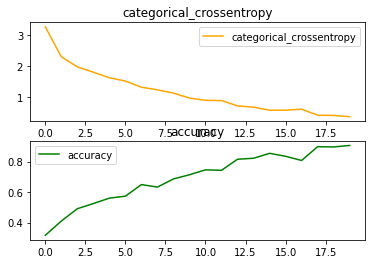

In [58]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.legend(["categorical_crossentropy"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.legend(["accuracy"])
plt.title("accuracy")
plt.show()

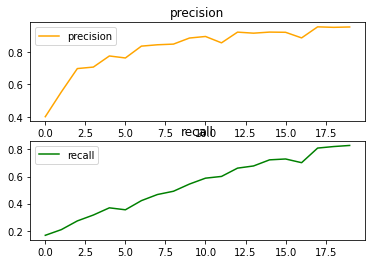

In [59]:
plt.subplot(2,1,1)
plt.plot(history.history["precision_3"], color='orange')
plt.legend(["precision"])
plt.title("precision")
plt.subplot(2,1,2)
plt.plot(history.history["recall_3"], color='green')
plt.legend(["recall"])
plt.title("recall")
plt.show()

**ANSWERS**

In [60]:
answer = mobile_model.evaluate(Temp_Train, output_matrix)
print("ACCURACY: ", round(answer[1], 2))
print("LOSS: ", round(answer[0], 2))
print("Precision: ", round(answer[2], 2))
print("Recall: ", round(answer[3], 2))

20/20 [==============================] - 1s 19ms/step - loss: 0.2835 - accuracy: 0.9388 - precision_3: 0.9702 - recall_3: 0.8905
ACCURACY:  0.94
LOSS:  0.28
Precision:  0.97
Recall:  0.89


In [61]:
pre = mobile_model.predict(Temp_Train)

20/20 [==============================] - 1s 15ms/step


In [62]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(output_matrix[i]))

<Axes: >

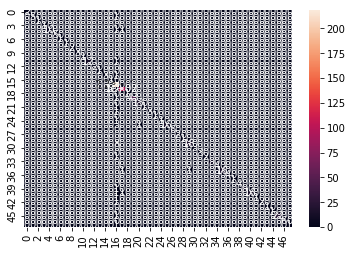

In [63]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

In [64]:
Print_data(y_real, y_pre)

for class 0: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 1: recall 0.8333, specificity 1.0            precision 1.0, f1 0.9091
for class 2: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 3: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 4: recall 0.8333, specificity 1.0            precision 1.0, f1 0.9091
for class 5: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 6: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 7: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 8: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 9: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 10: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 11: recall 0.9231, specificity 1.0            precision 1.0, f1 0.96
for class 12: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 13: recal

# BICUBIC MODEL

In [65]:
Temp_Train = []
for i in tqdm(range(len(LR)),desc="UPSAMPLING"):
  img = cv2.resize(LR[i], (128, 128), interpolation=cv2.INTER_CUBIC)
  Temp_Train.append(img)

UPSAMPLING: 100%|██████████| 621/621 [00:00<00:00, 6236.74it/s]


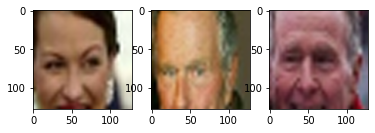

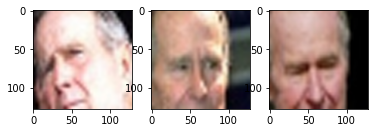

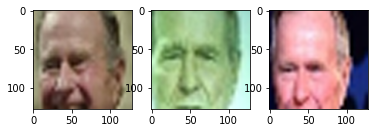

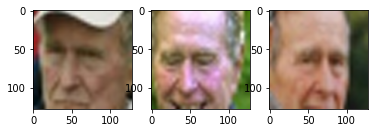

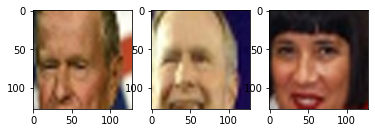

In [66]:
for i in range(0, 15, 3):
    f, axarr = plt.subplots(nrows=1,ncols=3)
    plt.sca(axarr[0]); 
    plt.imshow(Temp_Train[i])
    plt.sca(axarr[1]); 
    plt.imshow(Temp_Train[i+1])
    plt.sca(axarr[2]); 
    plt.imshow(Temp_Train[i+2])
    plt.show()

**RESULTS**

In [67]:
Print_ALL(np.array(Training), np.array(Temp_Train))

PSRN:  31.01


<ipython-input-10-f03d19e3d0da>:2: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return round(ssim(original, compressed, multichannel=True), 2)


SSIM:  0.94


In [68]:
Temp_Train = np.array(Temp_Train)
output_matrix =  np.array(output_matrix)

# RESNET50 MODEL

In [69]:
resnet_model = Sequential()
pretrained_mRESULTSodel= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(128, 128, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(2048, activation='relu'))
resnet_model.add(Dense(total, activation='softmax'))

In [70]:
resnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 flatten_6 (Flatten)         (None, 1280)              0         
                                                                 
 dense_15 (Dense)            (None, 2048)              2623488   
                                                                 
 dense_16 (Dense)            (None, 48)                98352     
                                                                 
Total params: 4,979,824
Trainable params: 2,721,840
Non-trainable params: 2,257,984
_________________________________________________________________


In [71]:
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = resnet_model.fit(Temp_Train, output_matrix, batch_size=32, epochs=20)

Epoch 1/20
20/20 [==============================] - 4s 20ms/step - loss: 3.5506 - accuracy: 0.2882 - precision_4: 0.3602 - recall_4: 0.1868
Epoch 2/20
20/20 [==============================] - 0s 16ms/step - loss: 2.3401 - accuracy: 0.4283 - precision_4: 0.5882 - recall_4: 0.1771
Epoch 3/20
20/20 [==============================] - 0s 17ms/step - loss: 2.0248 - accuracy: 0.4718 - precision_4: 0.6604 - recall_4: 0.2850
Epoch 4/20
20/20 [==============================] - 0s 17ms/step - loss: 1.7796 - accuracy: 0.5169 - precision_4: 0.7676 - recall_4: 0.2979
Epoch 5/20
20/20 [==============================] - 0s 16ms/step - loss: 1.6432 - accuracy: 0.5556 - precision_4: 0.7674 - recall_4: 0.3720
Epoch 6/20
20/20 [==============================] - 0s 17ms/step - loss: 1.5744 - accuracy: 0.5443 - precision_4: 0.7304 - recall_4: 0.3752
Epoch 7/20
20/20 [==============================] - 0s 16ms/step - loss: 1.4206 - accuracy: 0.5958 - precision_4: 0.7938 - recall_4: 0.3720
Epoch 8/20
20/20 [==

**Graphs**

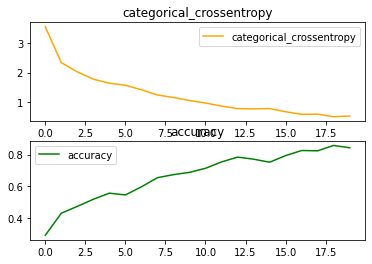

In [72]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.legend(["categorical_crossentropy"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.legend(["accuracy"])
plt.title("accuracy")
plt.show()

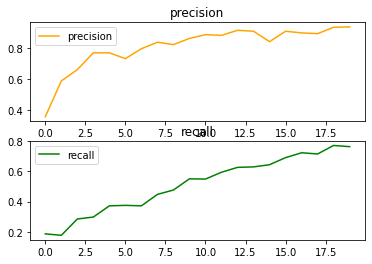

In [73]:
plt.subplot(2,1,1)
plt.plot(history.history["precision_4"], color='orange')
plt.legend(["precision"])
plt.title("precision")
plt.subplot(2,1,2)
plt.plot(history.history["recall_4"], color='green')
plt.legend(["recall"])
plt.title("recall")
plt.show()

**Answers**

In [74]:
answer = resnet_model.evaluate(Temp_Train, output_matrix)
print("ACCURACY: ", round(answer[1], 2))
print("LOSS: ", round(answer[0], 2))
print("Precision: ", round(answer[2], 2))
print("Recall: ", round(answer[3], 2))

20/20 [==============================] - 1s 17ms/step - loss: 0.5680 - accuracy: 0.8293 - precision_4: 0.9240 - recall_4: 0.7246
ACCURACY:  0.83
LOSS:  0.57
Precision:  0.92
Recall:  0.72


In [75]:
pre = resnet_model.predict(Temp_Train)

20/20 [==============================] - 1s 13ms/step


In [76]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(output_matrix[i]))

<Axes: >

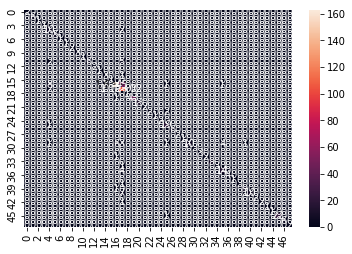

In [77]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

In [78]:
Print_data(y_real, y_pre)

for class 0: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 1: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 2: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 3: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 4: recall 0.8333, specificity 0.977            precision 0.4167, f1 0.5556
for class 5: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 6: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 7: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 8: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 9: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 10: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 11: recall 0.4615, specificity 1.0            precision 1.0, f1 0.6316
for class 12: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 13: reca

# MOBILENETv2

In [79]:
mobile_model = Sequential()
pretrained_model= MobileNetV2(include_top=False,
                   input_shape=(128, 128, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

mobile_model.add(pretrained_model)
mobile_model.add(Flatten())
mobile_model.add(Dense(2048, activation='relu'))
mobile_model.add(Dense(total, activation='softmax'))

In [80]:
mobile_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = mobile_model.fit(Temp_Train, output_matrix, batch_size=32, epochs=20)

Epoch 1/20
20/20 [==============================] - 4s 21ms/step - loss: 3.3065 - accuracy: 0.3060 - precision_5: 0.4028 - recall_5: 0.1836
Epoch 2/20
20/20 [==============================] - 0s 17ms/step - loss: 2.2139 - accuracy: 0.4525 - precision_5: 0.6800 - recall_5: 0.1916
Epoch 3/20
20/20 [==============================] - 0s 16ms/step - loss: 1.9248 - accuracy: 0.5121 - precision_5: 0.7431 - recall_5: 0.2609
Epoch 4/20
20/20 [==============================] - 0s 16ms/step - loss: 1.8251 - accuracy: 0.5282 - precision_5: 0.7407 - recall_5: 0.3221
Epoch 5/20
20/20 [==============================] - 0s 17ms/step - loss: 1.5924 - accuracy: 0.5491 - precision_5: 0.7882 - recall_5: 0.3655
Epoch 6/20
20/20 [==============================] - 0s 16ms/step - loss: 1.4422 - accuracy: 0.6167 - precision_5: 0.8374 - recall_5: 0.3897
Epoch 7/20
20/20 [==============================] - 0s 16ms/step - loss: 1.4192 - accuracy: 0.5797 - precision_5: 0.7563 - recall_5: 0.3897
Epoch 8/20
20/20 [==

**graphs**

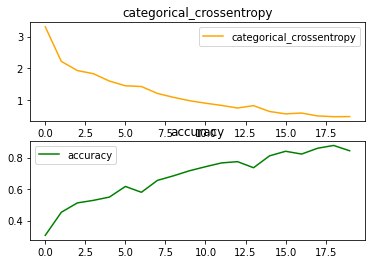

In [81]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.legend(["categorical_crossentropy"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.legend(["accuracy"])
plt.title("accuracy")
plt.show()

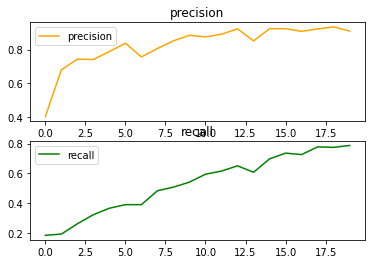

In [82]:
plt.subplot(2,1,1)
plt.plot(history.history["precision_5"], color='orange')
plt.legend(["precision"])
plt.title("precision")
plt.subplot(2,1,2)
plt.plot(history.history["recall_5"], color='green')
plt.legend(["recall"])
plt.title("recall")
plt.show()

**Answers**

In [83]:
answer = mobile_model.evaluate(Temp_Train, output_matrix)
print("ACCURACY: ", round(answer[1], 2))
print("LOSS: ", round(answer[0], 2))
print("Precision: ", round(answer[2], 2))
print("Recall: ", round(answer[3], 2))

20/20 [==============================] - 1s 20ms/step - loss: 0.3593 - accuracy: 0.9469 - precision_5: 0.9941 - recall_5: 0.8084
ACCURACY:  0.95
LOSS:  0.36
Precision:  0.99
Recall:  0.81


In [84]:
pre = mobile_model.predict(Temp_Train)

20/20 [==============================] - 1s 13ms/step


In [85]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(output_matrix[i]))

<Axes: >

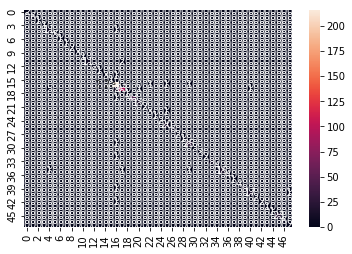

In [86]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

In [87]:
Print_data(y_real, y_pre)

for class 0: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 1: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 2: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 3: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 4: recall 0.9167, specificity 0.9901            precision 0.6471, f1 0.7586
for class 5: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 6: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 7: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 8: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 9: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 10: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 11: recall 0.8462, specificity 1.0            precision 1.0, f1 0.9167
for class 12: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 13: rec

# Original DATASET

In [88]:
resnet_model = Sequential()
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(128, 128, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(2048, activation='relu'))
resnet_model.add(Dense(total, activation='softmax'))

In [90]:
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = resnet_model.fit(np.array(Training), output_matrix, batch_size=32, epochs=20)

Epoch 1/20
20/20 [==============================] - 6s 40ms/step - loss: 4.7727 - accuracy: 0.3784 - precision_7: 0.5000 - recall_7: 0.2850
Epoch 2/20
20/20 [==============================] - 1s 35ms/step - loss: 1.2539 - accuracy: 0.7166 - precision_7: 0.8874 - recall_7: 0.5459
Epoch 3/20
20/20 [==============================] - 1s 35ms/step - loss: 0.6234 - accuracy: 0.8551 - precision_7: 0.9747 - recall_7: 0.7440
Epoch 4/20
20/20 [==============================] - 1s 34ms/step - loss: 0.3202 - accuracy: 0.9340 - precision_7: 0.9873 - recall_7: 0.8776
Epoch 5/20
20/20 [==============================] - 1s 36ms/step - loss: 0.1605 - accuracy: 0.9678 - precision_7: 0.9932 - recall_7: 0.9404
Epoch 6/20
20/20 [==============================] - 1s 38ms/step - loss: 0.0699 - accuracy: 0.9984 - precision_7: 1.0000 - recall_7: 0.9871
Epoch 7/20
20/20 [==============================] - 1s 38ms/step - loss: 0.0408 - accuracy: 1.0000 - precision_7: 1.0000 - recall_7: 0.9952
Epoch 8/20
20/20 [==

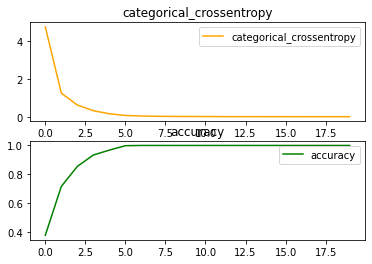

In [91]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.legend(["categorical_crossentropy"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.legend(["accuracy"])
plt.title("accuracy")
plt.show()

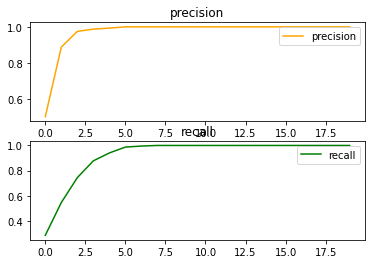

In [93]:
plt.subplot(2,1,1)
plt.plot(history.history["precision_6"], color='orange')
plt.legend(["precision"])
plt.title("precision")
plt.subplot(2,1,2)
plt.plot(history.history["recall_6"], color='green')
plt.legend(["recall"])
plt.title("recall")
plt.show()

In [95]:
answer = resnet_model.evaluate(np.array(Training), output_matrix)
print("ACCURACY: ", round(answer[1], 2))
print("LOSS: ", round(answer[0], 2))
print("Precision: ", round(answer[2], 2))
print("Recall: ", round(answer[3], 2))

20/20 [==============================] - 3s 37ms/step - loss: 0.0034 - accuracy: 1.0000 - precision_7: 1.0000 - recall_7: 1.0000
ACCURACY:  1.0
LOSS:  0.0
Precision:  1.0
Recall:  1.0


In [96]:
pre = resnet_model.predict(np.array(Training))

20/20 [==============================] - 2s 34ms/step


In [97]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(output_matrix[i]))

<Axes: >

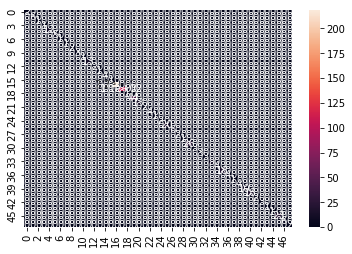

In [98]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

In [99]:
Print_data(y_real, y_pre)

for class 0: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 1: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 2: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 3: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 4: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 5: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 6: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 7: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 8: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 9: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 10: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 11: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 12: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 13: recall 1.0, specifici

In [100]:
mobile_model = Sequential()
pretrained_model= MobileNetV2(include_top=False,
                   input_shape=(128, 128, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

mobile_model.add(pretrained_model)
mobile_model.add(Flatten())
mobile_model.add(Dense(2048, activation='relu'))
mobile_model.add(Dense(total, activation='softmax'))

In [101]:
mobile_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = mobile_model.fit(np.array(Training), output_matrix, batch_size=32, epochs=20)

Epoch 1/20
20/20 [==============================] - 5s 20ms/step - loss: 3.4060 - accuracy: 0.2915 - precision_8: 0.3874 - recall_8: 0.1578
Epoch 2/20
20/20 [==============================] - 0s 16ms/step - loss: 2.1718 - accuracy: 0.4589 - precision_8: 0.6619 - recall_8: 0.2238
Epoch 3/20
20/20 [==============================] - 0s 16ms/step - loss: 1.9824 - accuracy: 0.4847 - precision_8: 0.7130 - recall_8: 0.2641
Epoch 4/20
20/20 [==============================] - 0s 15ms/step - loss: 1.7171 - accuracy: 0.5330 - precision_8: 0.7603 - recall_8: 0.3269
Epoch 5/20
20/20 [==============================] - 0s 17ms/step - loss: 1.5505 - accuracy: 0.5556 - precision_8: 0.7852 - recall_8: 0.3591
Epoch 6/20
20/20 [==============================] - 0s 16ms/step - loss: 1.4007 - accuracy: 0.5990 - precision_8: 0.8248 - recall_8: 0.4171
Epoch 7/20
20/20 [==============================] - 0s 17ms/step - loss: 1.3316 - accuracy: 0.6264 - precision_8: 0.7867 - recall_8: 0.4573
Epoch 8/20
20/20 [==

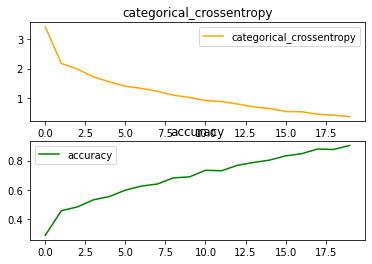

In [102]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.legend(["categorical_crossentropy"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.legend(["accuracy"])
plt.title("accuracy")
plt.show()

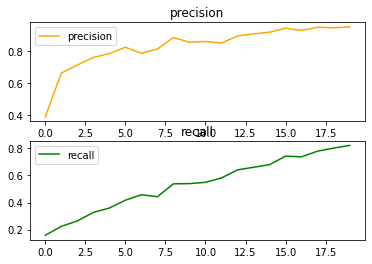

In [103]:
plt.subplot(2,1,1)
plt.plot(history.history["precision_7"], color='orange')
plt.legend(["precision"])
plt.title("precision")
plt.subplot(2,1,2)
plt.plot(history.history["recall_7"], color='green')
plt.legend(["recall"])
plt.title("recall")
plt.show()

In [105]:
answer = mobile_model.evaluate(np.array(Training), output_matrix)
print("ACCURACY: ", round(answer[1], 2))
print("LOSS: ", round(answer[0], 2))
print("Precision: ", round(answer[2], 2))
print("Recall: ", round(answer[3], 2))

20/20 [==============================] - 2s 21ms/step - loss: 0.3272 - accuracy: 0.9469 - precision_8: 0.9890 - recall_8: 0.8680
ACCURACY:  0.95
LOSS:  0.33
Precision:  0.99
Recall:  0.87


In [106]:
pre = mobile_model.predict(np.array(Training))

20/20 [==============================] - 2s 17ms/step


In [107]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(output_matrix[i]))

<Axes: >

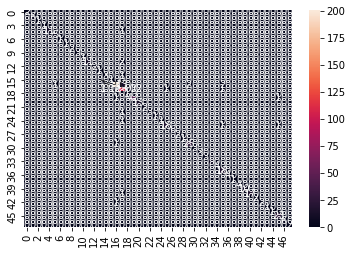

In [108]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

In [109]:
Print_data(y_real, y_pre)

for class 0: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 1: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 2: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 3: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 4: recall 0.9167, specificity 1.0            precision 1.0, f1 0.9565
for class 5: recall 1.0, specificity 0.9984            precision 0.8333, f1 0.9091
for class 6: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 7: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 8: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 9: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 10: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 11: recall 0.8462, specificity 1.0            precision 1.0, f1 0.9167
for class 12: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 13: 

# Low Resolution DATASET

In [110]:
resnet_model = Sequential()
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(32, 32, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(2048, activation='relu'))
resnet_model.add(Dense(total, activation='softmax'))

In [111]:
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = resnet_model.fit(np.array(LR), output_matrix, batch_size=32, epochs=20)

Epoch 1/20
20/20 [==============================] - 5s 30ms/step - loss: 7.2926 - accuracy: 0.3655 - precision_9: 0.4212 - recall_9: 0.3527
Epoch 2/20
20/20 [==============================] - 0s 15ms/step - loss: 1.3828 - accuracy: 0.7021 - precision_9: 0.8061 - recall_9: 0.6425
Epoch 3/20
20/20 [==============================] - 0s 14ms/step - loss: 0.4768 - accuracy: 0.8535 - precision_9: 0.9042 - recall_9: 0.8052
Epoch 4/20
20/20 [==============================] - 0s 14ms/step - loss: 0.2138 - accuracy: 0.9356 - precision_9: 0.9562 - recall_9: 0.9130
Epoch 5/20
20/20 [==============================] - 0s 14ms/step - loss: 0.0962 - accuracy: 0.9823 - precision_9: 0.9837 - recall_9: 0.9710
Epoch 6/20
20/20 [==============================] - 0s 14ms/step - loss: 0.0341 - accuracy: 0.9968 - precision_9: 0.9984 - recall_9: 0.9968
Epoch 7/20
20/20 [==============================] - 0s 14ms/step - loss: 0.0183 - accuracy: 0.9968 - precision_9: 0.9984 - recall_9: 0.9968
Epoch 8/20
20/20 [==

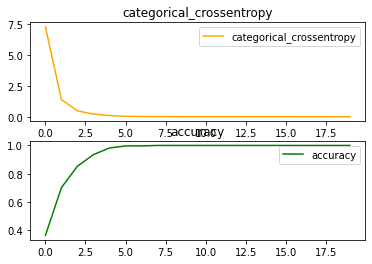

In [112]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.legend(["categorical_crossentropy"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.legend(["accuracy"])
plt.title("accuracy")
plt.show()

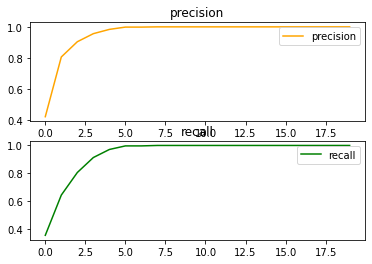

In [113]:
plt.subplot(2,1,1)
plt.plot(history.history["precision_8"], color='orange')
plt.legend(["precision"])
plt.title("precision")
plt.subplot(2,1,2)
plt.plot(history.history["recall_8"], color='green')
plt.legend(["recall"])
plt.title("recall")
plt.show()

In [114]:
answer = resnet_model.evaluate(np.array(LR), output_matrix)
print("ACCURACY: ", round(answer[1], 2))
print("LOSS: ", round(answer[0], 2))
print("Precision: ", round(answer[2], 2))
print("Recall: ", round(answer[3], 2))

20/20 [==============================] - 2s 20ms/step - loss: 0.0014 - accuracy: 1.0000 - precision_9: 1.0000 - recall_9: 1.0000
ACCURACY:  1.0
LOSS:  0.0
Precision:  1.0
Recall:  1.0


In [115]:
pre = resnet_model.predict(np.array(LR))

20/20 [==============================] - 1s 15ms/step


In [116]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(output_matrix[i]))

<Axes: >

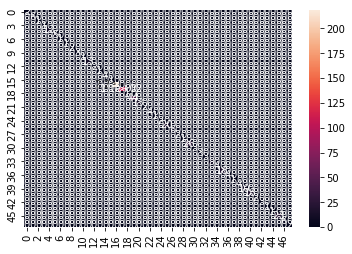

In [117]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

In [118]:
Print_data(y_real, y_pre)

for class 0: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 1: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 2: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 3: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 4: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 5: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 6: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 7: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 8: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 9: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 10: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 11: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 12: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 13: recall 1.0, specifici

In [119]:
mobile_model = Sequential()
pretrained_model= MobileNetV2(include_top=False,
                   input_shape=(32, 32, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

mobile_model.add(pretrained_model)
mobile_model.add(Flatten())
mobile_model.add(Dense(2048, activation='relu'))
mobile_model.add(Dense(total, activation='softmax'))

9406464/9406464 [==============================] - 0s 0us/step


In [120]:
mobile_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = mobile_model.fit(np.array(LR), output_matrix, batch_size=32, epochs=20)

Epoch 1/20
20/20 [==============================] - 5s 20ms/step - loss: 3.1963 - accuracy: 0.3301 - precision_10: 0.3333 - recall_10: 0.0048
Epoch 2/20
20/20 [==============================] - 0s 9ms/step - loss: 2.6509 - accuracy: 0.3510 - precision_10: 0.3548 - recall_10: 0.0709
Epoch 3/20
20/20 [==============================] - 0s 9ms/step - loss: 2.5729 - accuracy: 0.3591 - precision_10: 0.3182 - recall_10: 0.0225
Epoch 4/20
20/20 [==============================] - 0s 10ms/step - loss: 2.5108 - accuracy: 0.3575 - precision_10: 0.3125 - recall_10: 0.0161
Epoch 5/20
20/20 [==============================] - 0s 10ms/step - loss: 2.4670 - accuracy: 0.3623 - precision_10: 0.5833 - recall_10: 0.0113
Epoch 6/20
20/20 [==============================] - 0s 9ms/step - loss: 2.4275 - accuracy: 0.3720 - precision_10: 0.4217 - recall_10: 0.0564
Epoch 7/20
20/20 [==============================] - 0s 12ms/step - loss: 2.3848 - accuracy: 0.3720 - precision_10: 0.6129 - recall_10: 0.0306
Epoch 8/2

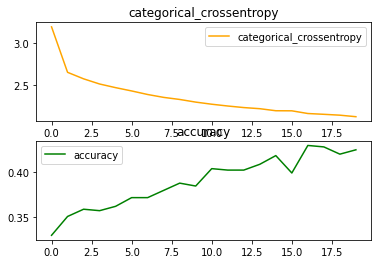

In [121]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.legend(["categorical_crossentropy"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.legend(["accuracy"])
plt.title("accuracy")
plt.show()

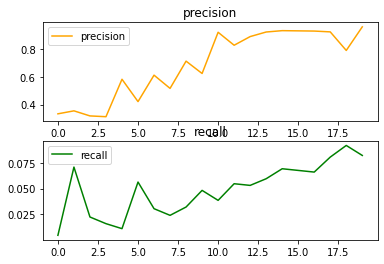

In [122]:
plt.subplot(2,1,1)
plt.plot(history.history["precision_9"], color='orange')
plt.legend(["precision"])
plt.title("precision")
plt.subplot(2,1,2)
plt.plot(history.history["recall_9"], color='green')
plt.legend(["recall"])
plt.title("recall")
plt.show()

In [123]:
answer = mobile_model.evaluate(np.array(LR), output_matrix)
print("ACCURACY: ", round(answer[1], 2))
print("LOSS: ", round(answer[0], 2))
print("Precision: ", round(answer[2], 2))
print("Recall: ", round(answer[3], 2))

20/20 [==============================] - 1s 11ms/step - loss: 2.0869 - accuracy: 0.4461 - precision_10: 0.9455 - recall_10: 0.0837
ACCURACY:  0.45
LOSS:  2.09
Precision:  0.95
Recall:  0.08


In [124]:
pre = mobile_model.predict(np.array(LR))

20/20 [==============================] - 1s 8ms/step


In [125]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(output_matrix[i]))

<Axes: >

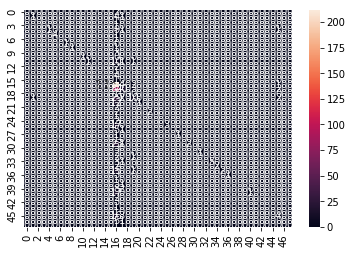

In [126]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

In [127]:
Print_data(y_real, y_pre)

for class 0: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 1: recall 0.1667, specificity 0.9984            precision 0.5, f1 0.25
for class 2: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 3: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 4: recall 0.0833, specificity 1.0            precision 1.0, f1 0.1538
for class 5: recall 0.8, specificity 1.0            precision 1.0, f1 0.8889
for class 6: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 7: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 8: recall 0.5, specificity 1.0            precision 1.0, f1 0.6667
for class 9: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 10: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 11: recall 0.0769, specificity 1.0            precision 1.0, f1 0.1429
for class 12: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 

<ipython-input-12-fd9aa6c65bf5>:10: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
